In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from matplotlib import pyplot as plt



In [2]:
# 假定读入二分类表格数据data，标签为data_label，需保证data全为数值型特征，若存在字符型，需编码为数值型
file1="data/4.75-yes-no.xlsx"
test_size=0.3
random_state=20


aggregate_data = pd.read_excel(file1,
                               sheet_name='4.75-del-9.5-500',
                               # encoding='gb18030'
                               )
# aggregate_data = pd.read_csv(file1,encoding='gb18030')
# print(aggregate_data.isnull())
aggregate_feature = aggregate_data.drop(['plyIndex','Pmoments_i2','Pmoments_i4','分档','target'], axis=1)#删除这些列的信息
# aggregate_feature = aggregate_data.drop(['plyindex','分档','target','Pmoments_i2','Pmoments_i4'], axis=1)  # 删除这些列的信息
aggregate_target = aggregate_data['target']
# aggregate_feature = aggregate_data.drop(['序号', '质量', '人工测量：长', '人工测量：高', '分档', '宽1', '宽2', '宽3', '人工测量：宽','边1','边2','边3','备注','Pinner_height', 'Pmoments_psi3','Pmoments_psi4','Pmax_diameter','Prect2_len1','Pinner_radius'], axis=1)  # 删除这些列的信息
# aggregate_target = aggregate_data['分档']

X = aggregate_feature#特征
y = aggregate_target#目标


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_test_v, val_x, y_test_v, val_y = train_test_split(X_test, y_test, test_size=test_size, random_state=random_state)

X_train = X_train.fillna(-1).values
val_x = val_x.fillna(-1).values
X_test = X_test.fillna(-1).values
y_train = y_train.values
val_y = val_y.values
y_test = y_test.values

In [3]:
tabnet_params = dict(
    n_d = 8,  # 可以理解为用来决定输出的隐藏层神经元个数。n_d越大，拟合能力越强，也容易过拟合
    n_a = 8,   # 可以理解为用来决定下一决策步特征选择的隐藏层神经元个数
    n_steps = 3, # 决策步的个数。可理解为决策树中分裂结点的次数
    gamma = 1.3,  # 决定历史所用特征在当前决策步的特征选择阶段的权重，gamma=1时，表示每个特征在所有决策步中至多仅出现1次
    lambda_sparse = 1e-3,  # 稀疏正则项权重，用来对特征选择阶段的特征稀疏性添加约束,越大则特征选择越稀疏
    optimizer_fn = torch.optim.Adam, # 优化器
    optimizer_params = dict(lr = 0.02, weight_decay = 1e-5),
    momentum = 0.03,
    mask_type = "entmax",
    seed = 0,
    scheduler_params = {"gamma": 0.95, "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    epsilon=1e-15,
)

clf = TabNetClassifier(**tabnet_params)
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (val_x, val_y)],
    eval_name=['train', 'valid'],
    eval_metric=['logloss', 'accuracy'],
    max_epochs=200,  # 最大迭代次数
    patience=50,    # 在验证集上早停次数，
    batch_size=128, # BN作用在的输入特征batch
    virtual_batch_size=16,  # 除了作用于模型输入特征的第一层BN外，都是用的是ghost BN。
    num_workers=0,
    drop_last=False,

)


Device used : cpu
epoch 0  | loss: 1.78127 | train_logloss: 9.16104 | train_accuracy: 0.13805 | valid_logloss: 8.54431 | valid_accuracy: 0.12451 |  0:00:01s
epoch 1  | loss: 1.11258 | train_logloss: 8.38611 | train_accuracy: 0.13855 | valid_logloss: 8.64081 | valid_accuracy: 0.11673 |  0:00:01s
epoch 2  | loss: 0.83938 | train_logloss: 8.26656 | train_accuracy: 0.13353 | valid_logloss: 8.17172 | valid_accuracy: 0.11284 |  0:00:02s
epoch 3  | loss: 0.69575 | train_logloss: 6.00081 | train_accuracy: 0.14006 | valid_logloss: 6.09219 | valid_accuracy: 0.11673 |  0:00:03s
epoch 4  | loss: 0.64653 | train_logloss: 5.30826 | train_accuracy: 0.16767 | valid_logloss: 5.33914 | valid_accuracy: 0.14786 |  0:00:04s
epoch 5  | loss: 0.64103 | train_logloss: 3.66858 | train_accuracy: 0.18524 | valid_logloss: 3.73722 | valid_accuracy: 0.16732 |  0:00:05s
epoch 6  | loss: 0.62887 | train_logloss: 3.45957 | train_accuracy: 0.16767 | valid_logloss: 3.58421 | valid_accuracy: 0.14397 |  0:00:06s
epoch 7  

In [4]:
print('文件名：',file1,'\n'
      'test_size:',test_size,'\n'
      '参数：',tabnet_params
                    )
# y_pred = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
# y_pred = clf.prepare_target(y_test)
# print(y_pred,y_test)
print('预测精度：',accuracy_score(y_test,y_pred))

print('精度报告')
print(metrics.classification_report(y_test, y_pred,digits=4))
his=clf.history

文件名： data/4.75-yes-no.xlsx 
test_size: 0.3 
参数： {'n_d': 8, 'n_a': 8, 'n_steps': 3, 'gamma': 1.3, 'lambda_sparse': 0.001, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02, 'weight_decay': 1e-05}, 'momentum': 0.03, 'mask_type': 'entmax', 'seed': 0, 'scheduler_params': {'gamma': 0.95, 'step_size': 20}, 'scheduler_fn': <class 'torch.optim.lr_scheduler.StepLR'>, 'epsilon': 1e-15}
预测精度： 0.9134502923976608
精度报告
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        95
           1     0.8824    1.0000    0.9375        90
           2     0.9790    0.8589    0.9150       163
           3     0.8400    0.9130    0.8750       207
           4     0.8883    0.8503    0.8689       187
           5     0.9730    0.9558    0.9643       113

    accuracy                         0.9135       855
   macro avg     0.9271    0.9297    0.9268       855
weighted avg     0.9169    0.9135    0.9136       855



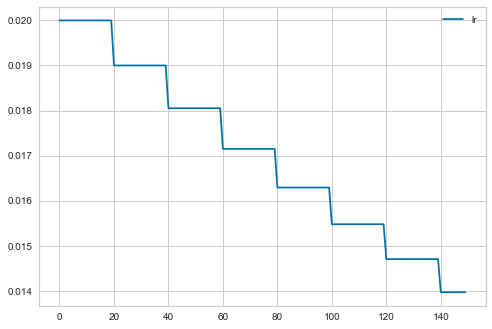

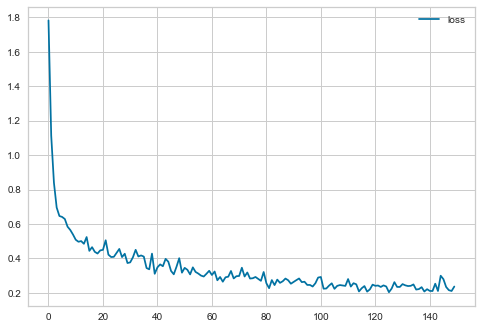

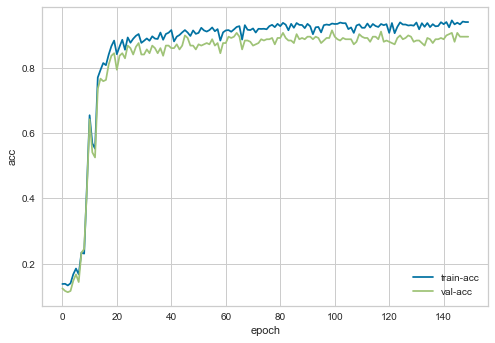

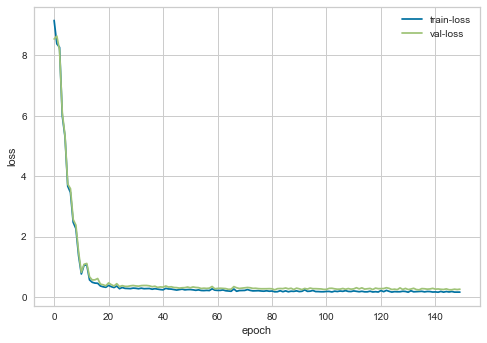

In [5]:
plt.plot(clf.history['lr'])
plt.legend(["lr"],loc="best")
plt.show()
plt.plot(clf.history['loss'])
plt.legend(["loss"],loc="best")
plt.show()

plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(["train-acc","val-acc"],loc="best")
plt.show()

plt.plot(clf.history['train_logloss'])
plt.plot(clf.history['valid_logloss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(["train-loss","val-loss"],loc="best")
plt.show()

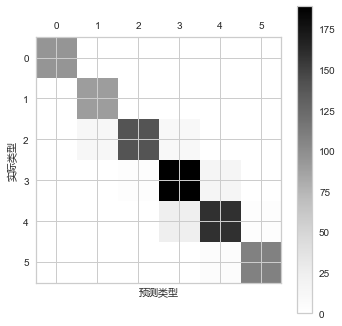

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\msyh.ttc", size=10)
# labels=['0','1','2','3','4','5']
maxtrix = confusion_matrix(y_test, y_pred)
plt.matshow(maxtrix)
plt.colorbar()
plt.xlabel('预测类型',fontproperties=font)
plt.ylabel('实际类型',fontproperties=font)
plt.xticks(np.arange(maxtrix.shape[1]))
plt.yticks(np.arange(maxtrix.shape[1]))
plt.show()

[[ 95   0   0   0   0   0]
 [  0  90   0   0   0   0]
 [  0  12 140  11   0   0]
 [  0   0   3 189  15   0]
 [  0   0   0  25 159   3]
 [  0   0   0   0   5 108]] <class 'numpy.ndarray'> [[1.         0.         0.         0.         0.         0.        ]
 [0.         1.         0.         0.         0.         0.        ]
 [0.         0.07361963 0.85889571 0.06748466 0.         0.        ]
 [0.         0.         0.01449275 0.91304348 0.07246377 0.        ]
 [0.         0.         0.         0.13368984 0.85026738 0.01604278]
 [0.         0.         0.         0.         0.04424779 0.95575221]]


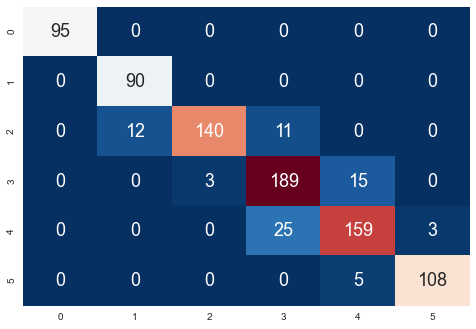

In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm_tab=confusion_matrix(y_test,y_pred)

con_mat_norm = cm_tab.astype('float') / cm_tab.sum(axis=1)[:, np.newaxis]##牛
print(cm_tab,type(cm_tab),con_mat_norm)
sns.heatmap(cm_tab,annot=True,cmap="RdBu_r",fmt="d",cbar=False, annot_kws={"size": 18})
plt.show()

<AxesSubplot:>

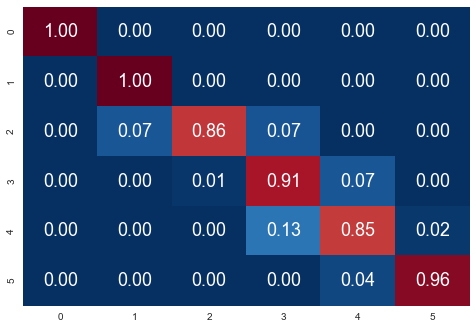

In [47]:
sns.heatmap(con_mat_norm,annot=True,cmap="RdBu_r",fmt=".2f",cbar=False, annot_kws={"size": 18})

In [54]:
import torch
print(torch.__version__)  #注意是双下划线
cuda_gpu = torch.cuda.is_available()   #判断GPU是否存在可用
print(cuda_gpu)

1.10.2+cpu
False
